In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
include("../src/worker_fct.jl")
using LaTeXStrings
data_type = "cal"
dat_col = "#009AF9";
sim_col = "#E26F46";

In [2]:
plots_path = "../plots/calib/"
base_path  = "../../waveforms/sim/wf/"
base_path_AE  = "../../waveforms/sim/wf_AE"
calib_filepath = "../dicts/calib.json"
cut_lib_filepath = "../dicts/cut_lib.json"
AE_cal_filepath = "../dicts/AE_cal.json"
sf_lib_filepath = "../dicts/sf_lib.json"
calib_filepath = "../dicts/calib.json"

calib = JSON.parsefile(calib_filepath)
AE_cal = JSON.parsefile(AE_cal_filepath)

photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2105.5, 2614.5]; # keV

# A & E determination uncertainty

From determining the A & E values from simulated DEP events

In [2]:
function model(x, par)
    scale = par[1]
    σ     = par[2]
    μ     = par[3]
    cp0   = par[4]
    return @. scale * exp(-0.5 * ((x - μ)^2) / (σ^2)) / (sqrt(2 * π * σ^2)) + cp0
end

model (generic function with 1 method)

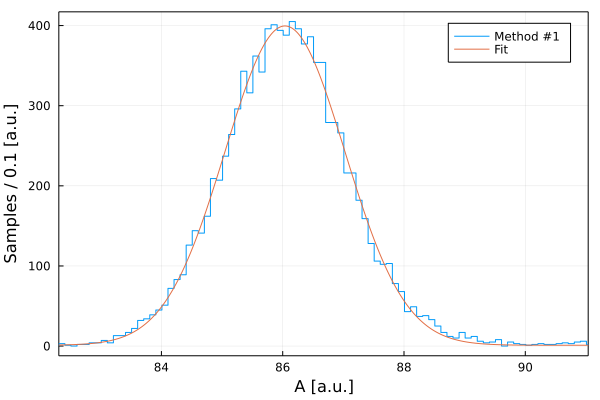

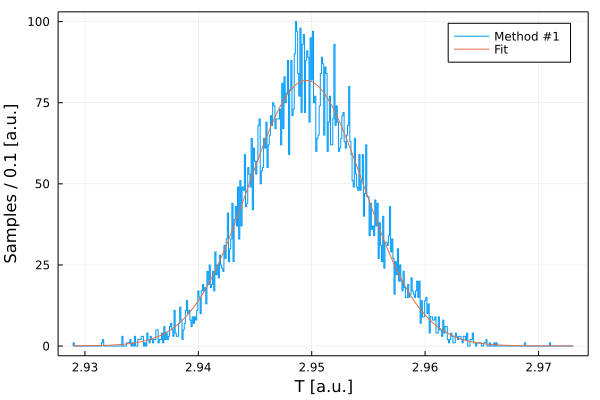

Ch35
1.149348488505332


In [14]:
for ch in 0:1:36
    if ctb[ch]
        set = "sim"
        ch_str = lpad(ch, 2, "0")

        calib = JSON.parsefile(calib_filepath)
        cut_lib = JSON.parsefile(cut_lib_filepath)
        AE_cal = JSON.parsefile(AE_cal_filepath)

        files = glob(joinpath(base_path, ch_str * "-" * ctn[ch] * "/*Tl*/*.h5"));
        E_rng = [1592.5,1592.51]
    
    
        numofele_A = 5
        BackDelta5 = div(numofele_A,2)
        ForwardDelta5 = isodd(numofele_A) ? div(numofele_A,2) : div(numofele_A,2) - 1
        numofele_E = 201
        BackDelta201 = div(numofele_E,2)
        ForwardDelta201 = isodd(numofele_E) ? div(numofele_E,2) : div(numofele_E,2) - 1

        DEP = []
        E = []
        t = []
        @showprogress "Ch" * ch_str * " - " * ctn[ch] * "... " for file in files
            data = HDF5.h5open(file, "r") do h5f
                LegendHDF5IO.readdata(h5f, "data")
            end;
            tmp = data |> @filter(Float64(sum(_.energy))*1000 > E_rng[1] && Float64(sum(_.energy))*1000 < E_rng[2] && length(_.energy) == 1) |> Table
            if size(tmp,1) > 0
                append!(DEP, tmp.waveform)
                append!(E, tmp.energy)
            end
        end

        A = []
        T = []
        rng_width = 3

        @showprogress for wf in DEP
            push!(A, maximum(movingaverage(diff(wf.value),numofele_A,BackDelta5,ForwardDelta5,3)))
            push!(T, maximum(movingaverage(diff(wf.value),numofele_E,BackDelta201,ForwardDelta201,13)))
        end

        fit_rng = minimum(A):0.1:maximum(A)
        h = fit(Histogram, A, fit_rng)
        plot(h, st=:step)


        xdata = midpoints(h.edges[1])
        ydata = h.weights
        x_max = xdata[findfirst(x->x == maximum(h.weights), h.weights)]
        p0 = float.([sum(ydata),1.0,x_max, 2])

        f = curve_fit(model, xdata, ydata, p0)
        par,err = f.param, stderror(f)

        p1 = plot(h, st=:step, label="Method #1")
        x_fit = fit_rng[1]:0.01:fit_rng[end]
        y_fit = model(x_fit, par)
        p1 = plot!(x_fit, y_fit, label="Fit")
        p1 = plot!(xlabel="A [a.u.]", ylabel="Samples / 0.1 [a.u.]", framestyle=:box)
        p1 = plot!(xlim=(minimum(A), par[3]+5))

        filename = "../plots/calib/" * ch_str * "-" * ctn[ch] * "/sim/A_uncert_DEP.pdf"
        savefig(p1, filename)
        
        !haskey(cut_lib[ctn[ch]], "A_uncert") ? cut_lib[ctn[ch]]["A_uncert"] = Dict() : ""
        cut_lib[ctn[ch]]["A_uncert"]["DEP"] = Dict()
        cut_lib[ctn[ch]]["A_uncert"]["DEP"]["uncert_in_percent"] = 100 * par[2] / par[3]
        cut_lib[ctn[ch]]["A_uncert"]["DEP"]["uncert_fit"] = [par, err]

        fit_rng = minimum(T):0.0001:maximum(T)
        h = fit(Histogram, T, fit_rng)
        plot(h, st=:step)


        xdata = midpoints(h.edges[1])
        ydata = h.weights
        x_max = xdata[findfirst(x->x == maximum(h.weights), h.weights)]
        p0 = float.([sum(ydata),0.001,x_max, 0.001])

        f = curve_fit(model, xdata, ydata, p0)
        par,err = f.param, stderror(f)

        p2 = plot(h, st=:step, label="Method #1")
        x_fit = fit_rng[1]:0.0001:fit_rng[end]
        y_fit = model(x_fit, par)
        p2 = plot!(x_fit, y_fit, label="Fit")
        p2 = plot!(xlabel="T [a.u.]", ylabel="Samples / 0.1 [a.u.]", framestyle=:box)

        filename = "../plots/calib/" * ch_str * "-" * ctn[ch] * "/sim/T_uncert_DEP.pdf"
        savefig(p2, filename)
        
        !haskey(cut_lib[ctn[ch]], "T_uncert") ? cut_lib[ctn[ch]]["T_uncert"] = Dict() : ""
        cut_lib[ctn[ch]]["T_uncert"]["DEP"] = Dict()
        cut_lib[ctn[ch]]["T_uncert"]["DEP"]["uncert_in_percent"] = 100 * par[2] / par[3]
        cut_lib[ctn[ch]]["T_uncert"]["DEP"]["uncert_fit"] = [par, err]
        
        open(cut_lib_filepath, "w") do f
            JSON.print(f, cut_lib, 4)
        end
        
        IJulia.clear_output(true)
        display(p1)
        display(p2)
        println("Ch" * ch_str)
        println(cut_lib[ctn[ch]]["A_uncert"]["DEP"]["uncert_in_percent"])
    end
end

# Calculate Cut uncertainties

### Data

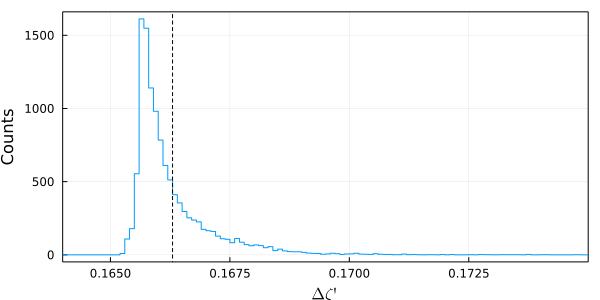

┌ Info: -1.65 ± 0.19
└ @ Main In[9]:71


Dict{String, Any} with 8 entries:
  "error_A"      => 0.0134525
  "run0080-0092" => Dict{String, Any}("error_A"=>0.0126463, "DEP_ref"=>Any[Dict…
  "DEP_ref"      => Any[Dict{String, Any}("d"=>55.7623, "bkg_l"=>330.975, "μ"=>…
  "summing"      => Dict{String, Any}("sf"=>Any[0.977133, 0.977133, 0.977725, 0…
  "error"        => 0.192043
  "error_diff"   => 0.0951
  "error_AoE"    => 0.1663
  "fitting"      => Dict{String, Any}("sf"=>Any[0.952873, 0.951755, 0.951875, 0…

In [9]:
calib_filepath = "../dicts/calib.json"
cut_lib_filepath = "../dicts/cut_lib.json"
AE_cal_filepath = "../dicts/AE_cal.json"

base_path_AE  = "../../waveforms/data/calib_AE/"
p = nothing
AoE = nothing
@showprogress for ch in [1]#0:1:36
    if ctb[ch] && !(ch in [5,6,7])
        calib = JSON.parsefile(calib_filepath)
        cut_lib = JSON.parsefile(cut_lib_filepath)
        AE_cal = JSON.parsefile(AE_cal_filepath)
        
        ch_str = lpad(ch, 2, "0");
        filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
        data = HDF5.h5open(filepath, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        set = "data";

        pl = 1592.5
        E_width = 10

        A = deepcopy(data.A)
        m,t = measurement.(calib[ctn[ch]][set]["lin_cal"][1], calib[ctn[ch]][set]["lin_cal"][2])
        E = data.E .* m .+ t

        index = findall(x->x.val > pl - E_width && x.val < pl + E_width, E)
        
        AoE = A[index] ./ E[index]
        AoE ./= calib[ctn[ch]][set]["AE_norm"]
        m, t = measurement.(AE_cal[ctn[ch]][set]["lin_fit"], AE_cal[ctn[ch]][set]["lin_fit_err"])
        AoE = AoE ./ (E[index] .* m .+ t)
        AoE ./= measurement.(AE_cal[ctn[ch]][set]["DEP_fit"][1]["μ"], AE_cal[ctn[ch]][set]["DEP_fit"][2]["μ"])
        AoE .-= 1
        a,b = measurement.(AE_cal[ctn[ch]][set]["sig_fit"], AE_cal[ctn[ch]][set]["sig_fit_err"])
        AoE = AoE ./ hypmodel(E[index], [a,b])
        
        errs = []
        errs_val = []
        
        @showprogress for v in AoE
            if v.val > -3 && v.val < 4
                push!(errs, abs(v.err / v.val))
                push!(errs_val, abs(v.err))
            end
        end
        
        h = fit(Histogram, errs_val, 0.0:0.0001:1.5)
        s = 0
        i = 1
        while s < length(errs_val) * 0.68
            s += h.weights[i]
            i += 1
        end
        p = plot(h, st=:step, label="ch" * ch_str)
        p = vline!([h.edges[1][i]], label=string(h.edges[1][i]), color=:black, style=:dash)
        if ch == 1
            p = plot!(framestyle=:box, xlabel=L"\Delta \zeta'", ylabel="Counts", legend=false, xlim=(0.164,0.175), size=(600,300))
        end
#         return p
        IJulia.clear_output(true)
        display(p)
        
        cut_lib = JSON.parsefile(cut_lib_filepath)
        cut = cut_lib[ctn[ch]]["data"]["fitting"]["cut"]
        cut_lib[ctn[ch]]["data"]["error_AoE"] = h.edges[1][i]
        cut_lib[ctn[ch]]["data"]["error_diff"] = abs(abs(cut) - abs(cut_lib[ctn[ch]]["data"]["summing"]["cut"]))
        cut_lib[ctn[ch]]["data"]["error_A"] = abs(cut * cut_lib[ctn[ch]]["A_uncert"]["DEP"]["uncert_in_percent"]/100)
        cut_lib[ctn[ch]]["data"]["error"] = sqrt(h.edges[1][i]^2 + cut_lib[ctn[ch]]["data"]["error_diff"]^2 + cut_lib[ctn[ch]]["data"]["error_A"]^2)
        @info(measurement(cut, cut_lib[ctn[ch]]["data"]["error"]))
        return cut_lib[ctn[ch]]["data"]
#         open(cut_lib_filepath, "w") do f
#             JSON.print(f, cut_lib, 4)
#         end
    end
end

### Simulation

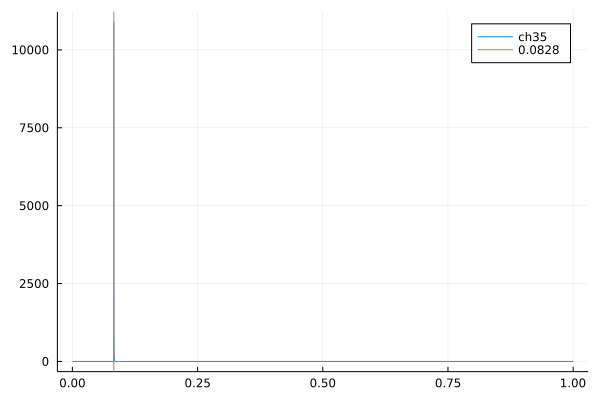

Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


In [4]:
calib_filepath = "../dicts/calib.json"
cut_lib_filepath = "../dicts/cut_lib.json"
AE_cal_filepath = "../dicts/AE_cal.json"

base_path_AE  = joinpath("../../waveforms/sim/", "calib_AE")
p = nothing
AoE = nothing
@showprogress for ch in 0:1:36
    if ctb[ch] && !(ch in [5,6,7])
        calib = JSON.parsefile(calib_filepath)
        cut_lib = JSON.parsefile(cut_lib_filepath)
        AE_cal = JSON.parsefile(AE_cal_filepath)
        
        ch_str = lpad(ch, 2, "0");
        filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
        data = HDF5.h5open(filepath, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        set = "sim";

        pl = 1592.5
        E_width = 10

        A = deepcopy(data.A)
        m,t = measurement.(calib[ctn[ch]][set]["lin_cal"][1], calib[ctn[ch]][set]["lin_cal"][2])
        E_uncal_smeared = (deepcopy(data.E) .- t.val) ./ m.val;
        E = E_uncal_smeared .* m .+ t

        index = findall(x->x.val > pl - E_width && x.val < pl + E_width, E)

        AoE = A[index] ./ E[index]
        AoE ./= calib[ctn[ch]][set]["AE_norm"]
        m, t = measurement.(AE_cal[ctn[ch]][set]["lin_fit"], AE_cal[ctn[ch]][set]["lin_fit_err"])
        AoE = AoE ./ (E[index] .* m .+ t)
        AoE ./= measurement.(AE_cal[ctn[ch]][set]["DEP_fit"][1]["μ"], AE_cal[ctn[ch]][set]["DEP_fit"][2]["μ"])
        AoE .-= 1
        a,b = measurement.(AE_cal[ctn[ch]][set]["sig_fit"], AE_cal[ctn[ch]][set]["sig_fit_err"])
        AoE = AoE ./ hypmodel(E[index], [a,b])
        
        errs = []
        errs_val = []
        
        @showprogress for v in AoE
            if v.val > -3 && v.val < 4
                push!(errs, abs(v.err / v.val))
                push!(errs_val, abs(v.err))
            end
        end
        mean(errs), mean(errs_val)
        h = fit(Histogram, errs_val, 0.0:0.0001:1.)
        s = 0
        i = 1
        while s < length(errs_val) * 0.68
            s += h.weights[i]
            i += 1
        end
        p = plot(h, st=:step, label="ch" * ch_str)
        p = vline!([h.edges[1][i]], label=string(h.edges[1][i]))
        IJulia.clear_output(true)
        display(p)
        
        
        cut_lib = JSON.parsefile(cut_lib_filepath)
        cut = abs(cut_lib[ctn[ch]]["sim"]["fitting"]["cut"])
        cut_lib[ctn[ch]][set]["error_AoE"] = h.edges[1][i]
        cut_lib[ctn[ch]][set]["error_diff"] = abs(cut - abs(cut_lib[ctn[ch]][set]["summing"]["cut"]))
        cut_lib[ctn[ch]][set]["error_A"] = abs(cut * cut_lib[ctn[ch]]["A_uncert"]["DEP"]["uncert_in_percent"]/100)
        cut_lib[ctn[ch]][set]["error"] = sqrt(h.edges[1][i]^2 + cut_lib[ctn[ch]][set]["error_diff"]^2 + cut_lib[ctn[ch]][set]["error_A"]^2)
#         return cut_lib[ctn[ch]]["sim"]
        open(cut_lib_filepath, "w") do f
            JSON.print(f, cut_lib, 4)
        end
    end
end